In [4]:
import os
import pandas as pd
import numpy as np
import talib

### **csv파일 불러오기**

In [5]:
df = pd.read_csv('F:\\jupyter_project\\valid\\Using GAN\\dataset\\XRP_1mm_(2020-01-05 ~ 2020-07-01)_columns.csv')
df

,date,open,high,low,close,volume
0,2020-07-01T21:36:00,211,211,211,211,110
1,2020-07-01T21:35:00,210,211,210,211,20663
2,2020-07-01T21:34:00,209,210,209,210,360996
3,2020-07-01T21:33:00,209,210,209,209,164921
4,2020-07-01T21:32:00,209,209,209,209,947
...,...,...,...,...,...,...
230303,2020-01-01T00:04:00,222,222,221,221,29121
230304,2020-01-01T00:03:00,222,223,222,223,157221
230305,2020-01-01T00:02:00,221,222,221,222,93001
230306,2020-01-01T00:01:00,222,222,221,221,114284


In [6]:
df=df[::-1]
df=df.reset_index(drop=True)
#df.rename(columns={"final":"close","vol":"volume"}, inplace = True)

df

,date,open,high,low,close,volume
0,2020-01-01T00:00:00,222,223,222,222,41301
1,2020-01-01T00:01:00,222,222,221,221,114284
2,2020-01-01T00:02:00,221,222,221,222,93001
3,2020-01-01T00:03:00,222,223,222,223,157221
4,2020-01-01T00:04:00,222,222,221,221,29121
...,...,...,...,...,...,...
230303,2020-07-01T21:32:00,209,209,209,209,947
230304,2020-07-01T21:33:00,209,210,209,209,164921
230305,2020-07-01T21:34:00,209,210,209,210,360996
230306,2020-07-01T21:35:00,210,211,210,211,20663


In [7]:
def Indicators(df): # date close open high low volume 컬럼순 
                    # 결측치 33줄 생김 0~32 까지
    df['sma5'] = talib.SMA(np.asarray(df['close']), 5)
    df['sma20'] = talib.SMA(np.asarray(df['close']), 20)
    #df['sma120'] = talib.SMA(np.asarray(df['close']), 120)
    df['ema12'] = talib.SMA(np.asarray(df['close']), 12)
    df['ema26'] = talib.SMA(np.asarray(df['close']), 26)
    upper, middle, lower = talib.BBANDS(np.asarray(df['close']), timeperiod=20, nbdevup=2, nbdevdn=2, matype=0)
    df['dn'] = lower
    df['mavg'] = middle
    df['up'] = upper
    df['pctB'] = (df.close - df.dn)/(df.up - df.dn)
    rsi14 = talib.RSI(np.asarray(df['close']), 14)
    df['rsi14'] = rsi14
    macd, macdsignal, macdhist = talib.MACD(np.asarray(df['close']), 12, 26, 9)  
    df['macd'] = macd
    df['macdsignal'] = macdsignal
    df['obv']=talib.OBV(df['close'], df['volume'])
    df['ad'] = talib.AD(df['high'], df['low'], df['close'], df['volume'])
    df['ADOSC'] = talib.ADOSC(df['high'], df['low'], df['close'], df['volume'], fastperiod=3, slowperiod=10)
    return df

In [8]:
df[['close','open','high','low','volume']]=df[['close','open','high','low','volume']].astype(float)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 230308 entries, 0 to 230307
Data columns (total 6 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   date    230308 non-null  object 
 1   open    230308 non-null  float64
 2   high    230308 non-null  float64
 3   low     230308 non-null  float64
 4   close   230308 non-null  float64
 5   volume  230308 non-null  float64
dtypes: float64(5), object(1)
memory usage: 10.5+ MB


In [9]:
df=Indicators(df)

df.loc[32:33]

,date,open,high,low,close,volume,sma5,sma20,ema12,ema26,dn,mavg,up,pctB,rsi14,macd,macdsignal,obv,ad,ADOSC
32,2020-01-01T00:43:00,222.0,222.0,222.0,222.0,153.0,221.4,221.15,221.250000,221.230769,220.196061,221.15,222.103939,0.945521,54.198501,NaN,NaN,95779.0,195575.0,932.851889
33,2020-01-01T00:47:00,222.0,222.0,222.0,222.0,189.0,221.6,221.15,221.333333,221.230769,220.196061,221.15,222.103939,0.945521,54.198501,-0.012568,-0.195136,95779.0,195575.0,732.753313


In [10]:
import os
import pandas as pd
import numpy as np

from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, CuDNNLSTM, BatchNormalization, GRU
from keras.optimizers import Nadam, Adam
from keras.callbacks import TensorBoard
from keras.callbacks import ModelCheckpoint

from sklearn.preprocessing import MinMaxScaler,RobustScaler
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
import math


look_back = 25
def create_dataset(dataset, look_back=25):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i + look_back)].values.tolist()
        dataX.append(a)
        dataY.append(dataset.iloc[i + look_back]['close'])
    return np.array(dataX), np.array(dataY)

df=df.iloc[33:]
df=df.fillna(0)
df=df.drop(columns=['date'])
nptf=np.array(df)

Using TensorFlow backend.


In [11]:
# 정규화
#Xscaler = RobustScaler()
Xscaler = MinMaxScaler(feature_range=(0, 1))
#Yscaler = RobustScaler()
Yscaler = MinMaxScaler(feature_range=(0, 1))
Xscaler.fit(nptf)
Yscaler.fit(nptf[:,3].reshape(-1,1))

nptf = pd.DataFrame(Xscaler.transform(nptf),columns=df.columns)

In [12]:
# split train, test
train_size = int(len(nptf) * 0.95)
test_size = len(nptf) - train_size
train, test = nptf[0:train_size], nptf[train_size:len(nptf)]
print(len(train), len(test))
 
# create dataset for learning
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

218761 11514


In [13]:
df

,open,high,low,close,volume,sma5,sma20,ema12,ema26,dn,mavg,up,pctB,rsi14,macd,macdsignal,obv,ad,ADOSC
33,222.0,222.0,222.0,222.0,189.0,221.6,221.15,221.333333,221.230769,220.196061,221.15,222.103939,0.945521,54.198501,-0.012568,-0.195136,95779.0,1.955750e+05,732.753313
34,222.0,222.0,222.0,222.0,227.0,221.6,221.20,221.416667,221.269231,220.180196,221.20,222.219804,0.892232,54.198501,0.036429,-0.148823,95779.0,1.955750e+05,584.280868
35,222.0,222.0,221.0,221.0,77141.0,221.6,221.20,221.416667,221.230769,220.180196,221.20,222.219804,0.401942,46.659870,-0.005370,-0.120132,18638.0,1.184340e+05,-24074.437939
36,221.0,221.0,221.0,221.0,2800.0,221.6,221.20,221.416667,221.230769,220.180196,221.20,222.219804,0.401942,46.659870,-0.038057,-0.103717,18638.0,1.184340e+05,-31973.510365
37,221.0,222.0,221.0,222.0,31528.0,221.6,221.25,221.500000,221.269231,220.177619,221.25,222.322381,0.849689,54.069195,0.016539,-0.079666,50166.0,1.499620e+05,-22266.629961
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
230303,209.0,209.0,209.0,209.0,947.0,209.4,209.50,209.166667,209.807692,207.887548,209.50,211.112452,0.344957,42.939827,-0.307626,-0.327828,-27797735.0,2.838646e+08,-17099.677958
230304,209.0,210.0,209.0,209.0,164921.0,209.2,209.40,209.166667,209.730769,207.930306,209.40,210.869694,0.363917,42.939827,-0.310483,-0.324359,-27797735.0,2.836997e+08,-66342.849346
230305,209.0,210.0,209.0,210.0,360996.0,209.4,209.35,209.250000,209.730769,208.042330,209.35,210.657670,0.748534,53.812982,-0.229411,-0.305369,-27436739.0,2.840607e+08,34405.748663
230306,210.0,211.0,210.0,211.0,20663.0,209.6,209.35,209.416667,209.730769,208.042330,209.35,210.657670,1.130893,61.677333,-0.083506,-0.260997,-27416076.0,2.840814e+08,79067.879788


In [16]:
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0],  trainX.shape[1],19))
trainX.shape

(218735, 25, 19)

In [17]:
testX = np.reshape(testX, (testX.shape[0],  testX.shape[1],19))
testX.shape

(11488, 25, 19)

In [20]:
import time
NAME = f"{int(time.time())}"
tensorboard = TensorBoard(log_dir="./path/logs/{}".format(NAME))

# simple lstm network learning
model = Sequential()
model.add(LSTM(200))
model.add(Dropout(0.1))
model.add(Dense(1))

opt = Adam(lr=0.0005)

#model.compile(optimizer='rmsprop' loss='binary_crossentropy' metrics= ['accuracy'] )
model.compile(loss='mean_squared_error', optimizer=opt, metrics=['accuracy'])
#model.compile(loss='categorical_crossentropy', optimizer = Nadam(lr=1e-4), metrics=["accuracy"])

filepath = "{epoch:02d}-{loss:.3f}"
checkpoint = ModelCheckpoint("./models/{}.model".format(filepath, monitor='loss', verbose=1, save_best_only=True, mode='auto'))

model.fit(trainX, trainY, epochs=20, batch_size=512, verbose=1, callbacks = [tensorboard, checkpoint])

ValueError: Input 0 is incompatible with layer lstm_4: expected ndim=3, found ndim=2

In [15]:
# make prediction
testPredict = model.predict(testX)
testPredict = Yscaler.inverse_transform(testPredict)
testY = Yscaler.inverse_transform(testY.reshape(-1,1))
testScore = math.sqrt(mean_squared_error(testY, testPredict))
print('Train Score: %.2f RMSE' % testScore)

Train Score: 2.63 RMSE


In [16]:
model.save("models/%.2f"%(testScore))
model.save("models/%.2f.h5" % (testScore))

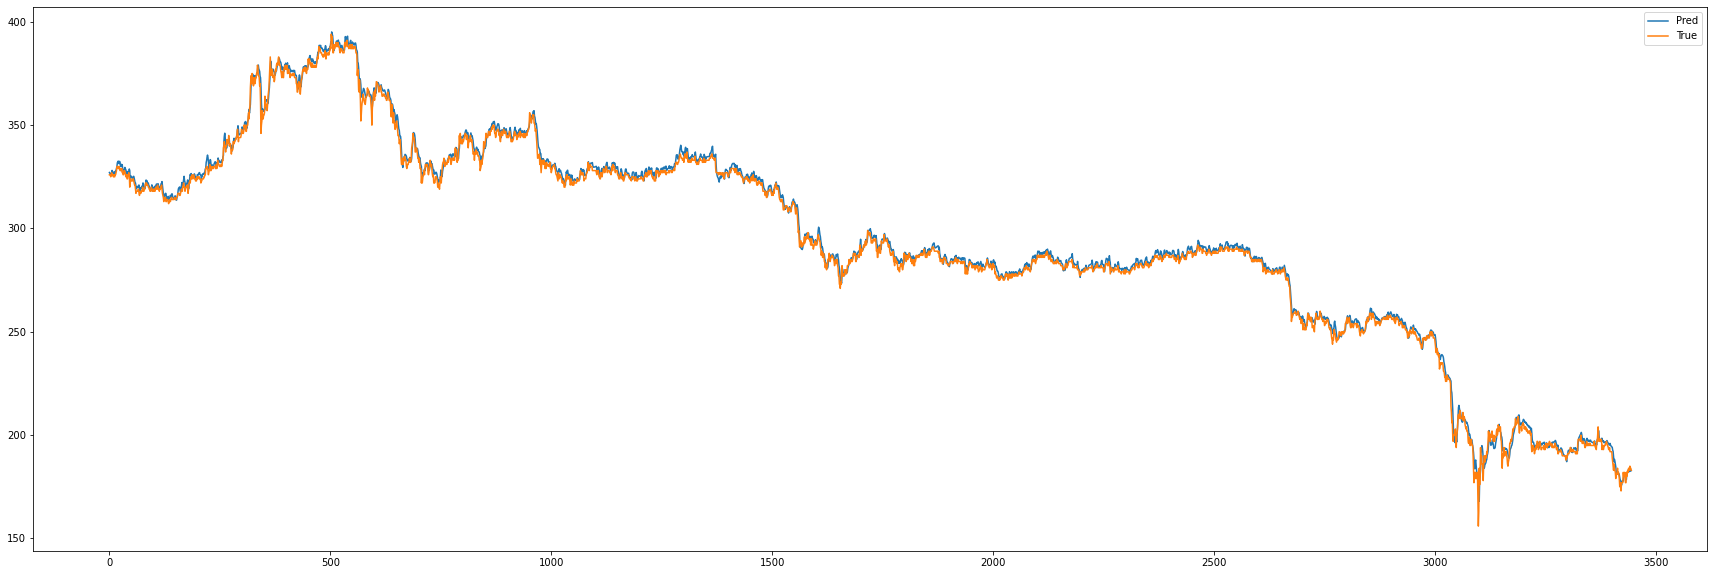

In [18]:
# plot
fig = plt.figure(facecolor='white', figsize=(30, 10))
ax = fig.add_subplot(111)
plt.plot(testPredict,label='Pred')
plt.plot(testY,label='True')
ax.legend()
plt.show()

In [ ]:
'''
from sklearn.externals import joblib 
# 객체를 pickled binary file 형태로 저장한다 
file_name = 'Xscale.pkl' 
joblib.dump(Xscaler, file_name) 
file_name = 'Yscale.pkl' 
joblib.dump(Yscaler, file_name)

from keras.models import load_model
model.save('LSTM.h5')

xs=joblib.load('Xscale.pkl')
ys=joblib.load('Yscale.pkl')
LSTM = load_model('LSTM.h5')

# make prediction
tp = LSTM.predict(testX)
tp = ys.inverse_transform(tp)

# plot
plt.rcParams["figure.figsize"] = (10,10)
plt.plot(testPredict)
#plt.plot(testY)
plt.plot(tp)
plt.show()

def create_dataset(dataset):
    dataX, dataY = [], []
    for i in range(len(dataset)-1):
        a = dataset.iloc[i].values.tolist()
        dataX.append(a)
        dataY.append(dataset.iloc[i+1]['close'])
    return np.array(dataX), np.array(dataY)

nptf

nptf = pd.DataFrame(nptf,columns=df.columns)

# split train, test
train_size = int(len(nptf) * 0.95)
test_size = len(nptf) - train_size
train, test = nptf[0:train_size], nptf[train_size:len(nptf)]
print(len(train), len(test))
 
# create dataset for learning
trainX, trainY = create_dataset(train)
testX, testY = create_dataset(test)

import lightgbm as lgb
train_ds = lgb.Dataset(trainX, label = trainY) 
test_ds = lgb.Dataset(testX, label = testY) 

params = {'learning_rate': 0.01, 
          'max_depth': 16, 
          'boosting': 'gbdt', 
          'objective': 'regression', 
          'metric': 'mse', 
          'is_training_metric': True, 
          'num_leaves': 144, 
          'feature_fraction': 0.9, 
          'bagging_fraction': 0.7, 
          'bagging_freq': 5, 
          'seed':2018}

params = {'learning_rate': 0.01,
          'boosting': 'gbdt', 
          'objective': 'regression', 
          'metric': 'mse'
          }

model = lgb.train(params, train_ds, 1000, test_ds, verbose_eval=100, early_stopping_rounds=100)

file_name = 'lgb2.pkl' 
joblib.dump(model, file_name) 

predict_test = model.predict(testX)

# plot
plt.rcParams["figure.figsize"] = (10,10)
plt.plot(testY)
plt.plot(predict_test)
plt.show()

import xgboost
model = xgboost.XGBRegressor(learning_rate=0.1,
                             max_depth=5,
                             n_estimators=100) 
model.fit(trainX,trainY,verbose=1)

file_name = 'xgb.pkl' 
joblib.dump(model, file_name) 

predict_test = model.predict(testX)

# plot
plt.rcParams["figure.figsize"] = (10,10)
plt.plot(testY)
#plt.plot(testY)
plt.plot(predict_test)
plt.show()
'''